In [1]:
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as LinReg
from sklearn.utils import resample


class regression():
    def __init__(self, complexity: int, seed: int):
        
        self.complexity = complexity
        
        self.rng = np.random.default_rng(seed=seed)
        self.seed = seed
    
        self.url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
        self.dataframe = read_csv(self.url, header=None)
        # separate into inputs and outputs
        self.data = self.dataframe.values
        self.X, self.y = self.data[:, :-1], self.data[:, -1]
        # split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.25, random_state=seed)

    
    def bootstrap_ols(self, degree: int, max_bootstrap_cycle: int, n_val, lamb: float = 0, alpha: float = 0):

        X_train = self.X_train[:, :degree]
        X_test = self.X_test[:, :degree]
            
        for bootstrap_cycle in range(max_bootstrap_cycle):
            
            X_train_resampled, y_train_resampled = resample(X_train, self.y_train, random_state=seed * bootstrap_cycle)

            if not lamb == 0:
                ridge = LinReg.Ridge(alpha=lamb, random_state=seed)
                mse, bias, var = bias_variance_decomp(ridge, X_train_resampled, y_train_resampled, X_test, self.y_test, loss='mse', num_rounds=n_val, random_seed=seed)
                
            
            elif not alpha == 0:
                lasso = LinReg.Lasso(alpha=alpha, random_state=seed)
                mse, bias, var = bias_variance_decomp(lasso, X_train_resampled, y_train_resampled, X_test, self.y_test, loss='mse', num_rounds=n_val, random_seed=seed)
        
            else: 
                ols = LinReg.LinearRegression()
                mse, bias, var = bias_variance_decomp(ols, X_train_resampled, y_train_resampled, X_test, self.y_test, loss='mse', num_rounds=n_val, random_seed=seed)
        
        return mse/100, bias/100, var/100
    
    def dt(self, degree: int, max_bootstrap_cycle: int, n_val):
        
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        
        
        for bootstrap_cycle in range(max_bootstrap_cycle):
            
            X_train_resampled, y_train_resampled = resample(X_train, y_train, random_state=seed * bootstrap_cycle)
            tree = DecisionTreeRegressor(random_state=seed)
            tree.fit(X_train_resampled, y_train_resampled)
            feat_array = tree.feature_importances_

            df_feat = pd.DataFrame()
            name_list, importance_list = [], []
            for name, importance in zip(range(X_train_resampled.shape[1]), feat_array):
                name_list.append(name)
                importance_list.append(importance)
            df_feat['name'] = name_list
            df_feat['importance'] = importance_list


            complexity = degree
            degrees = np.arange(1, complexity + 1)
            mse = np.zeros(complexity)
            bias = np.zeros(complexity)
            var = np.zeros(complexity)
            for i, deg in enumerate(degrees):
                top_feat = df_feat.sort_values(by = 'importance', ascending = False).head(deg)['name'].values
                X_train_fs = X_train_resampled[:, top_feat]
                X_test_fs = X_test[:, top_feat]
                mse[i], bias[i], var[i] = bias_variance_decomp(tree, X_train_fs, y_train_resampled, X_test_fs, y_test, loss='mse', num_rounds=n_val, random_seed=seed)
            
            print(f"Bootstrap cycle: {1 + bootstrap_cycle}")
                        
        return mse/100, bias/100, var/100
    
    def nn(self, degree: int, max_bootstrap_cycle: int, n_val):
        
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        
        for bootstrap_cycle in range(max_bootstrap_cycle):
            
            X_train_resampled, y_train_resampled = resample(X_train, y_train, random_state=seed * bootstrap_cycle)
        
            complexity = degree
            degrees = np.arange(1, complexity + 1)
            mse = np.zeros(complexity)
            bias = np.zeros(complexity)
            var = np.zeros(complexity)
            for i, deg in enumerate(degrees):
                nn = MLPRegressor(random_state=seed, hidden_layer_sizes=deg, tol=1e-1, max_iter=1000)
                nn.fit(X_train_resampled, y_train_resampled)
                mse[i], bias[i], var[i] = bias_variance_decomp(nn, X_train_resampled, y_train_resampled, X_test, y_test, loss='mse', num_rounds=n_val, random_seed=seed)
                print(f"Complexity: {deg}")
            print(f"Bootstrap cycle: {1 + bootstrap_cycle}")
            
        return mse/100, bias/100, var/100
    
    def rf(self, degree: int, max_bootstrap_cycle: int, n_val):
        
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        
        
        for bootstrap_cycle in range(max_bootstrap_cycle):
            
            X_train_resampled, y_train_resampled = resample(X_train, y_train, random_state=seed * bootstrap_cycle)
            tree = RandomForestRegressor(random_state=seed)
            tree.fit(X_train_resampled, y_train_resampled)
            feat_array = tree.feature_importances_

            df_feat = pd.DataFrame()
            name_list, importance_list = [], []
            for name, importance in zip(range(X_train_resampled.shape[1]), feat_array):
                name_list.append(name)
                importance_list.append(importance)
            df_feat['name'] = name_list
            df_feat['importance'] = importance_list


            complexity = degree
            degrees = np.arange(1, complexity + 1)
            mse = np.zeros(complexity)
            bias = np.zeros(complexity)
            var = np.zeros(complexity)
            for i, deg in enumerate(degrees):
                top_feat = df_feat.sort_values(by = 'importance', ascending = False).head(deg)['name'].values
                X_train_fs = X_train_resampled[:, top_feat]
                X_test_fs = X_test[:, top_feat]
                mse[i], bias[i], var[i] = bias_variance_decomp(tree, X_train_fs, y_train_resampled, X_test_fs, y_test, loss='mse', num_rounds=n_val, random_seed=seed)
                print(f"Complexity: {deg}")
            print(f"Bootstrap cycle: {1 + bootstrap_cycle}")
                        
        return mse/100, bias/100, var/100
    
#Seed
seed = 3754
#seed = np.random.integers(0, 5000)
#print(seed)

n_val = [200]
max_bootstrap_cycle = [1, 25, 50, 100]
complexity = 12
degrees = np.arange(1, complexity + 1)

#RNG
rng = np.random.default_rng(seed=seed)

reg = regression(complexity, seed)


MSE: 0.7192753133445899, Bias: 0.7164669860650023, Variance: 0.0028083272795876462, Complexity: 1
MSE: 0.6421284313812599, Bias: 0.6377388756576461, Variance: 0.0043895557236138, Complexity: 2
MSE: 0.5768443094026615, Bias: 0.5708841940946217, Variance: 0.005960115308040225, Complexity: 3
MSE: 0.5476609694386357, Bias: 0.5369175603230726, Variance: 0.010743409115563119, Complexity: 4
MSE: 0.549428079360727, Bias: 0.5377975640901317, Variance: 0.011630515270595365, Complexity: 5
MSE: 0.24450394411791468, Bias: 0.2334226363295625, Variance: 0.011081307788352156, Complexity: 6
MSE: 0.24465963509165087, Bias: 0.23269833602187223, Variance: 0.011961299069778622, Complexity: 7
MSE: 0.21461929606420424, Bias: 0.2035513278832378, Variance: 0.011067968180966338, Complexity: 8
MSE: 0.21562017691376892, Bias: 0.20275185633843226, Variance: 0.012868320575336671, Complexity: 9
MSE: 0.21350552084008512, Bias: 0.2003733307480437, Variance: 0.013132190092041498, Complexity: 10
MSE: 0.23614939864857845

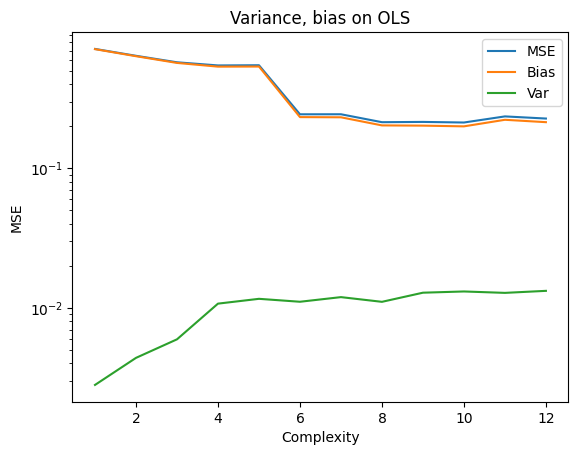

In [2]:
#Performing bootstrap on standard OLS
    
mse = np.zeros(complexity)
bias = np.zeros(complexity)
var = np.zeros(complexity)

for i, deg in enumerate(degrees):
    mse[i], bias[i], var[i] = reg.bootstrap_ols(degree=deg, max_bootstrap_cycle=max_bootstrap_cycle[2], n_val=n_val[0], lamb=0, alpha=0)
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")

        
plt.figure(0)
plt.title("Variance, bias on OLS")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_ols', dpi=300)
plt.show()


MSE: 0.719275330036289, Bias: 0.7164670038675479, Variance: 0.002808326168740929, Complexity: 1
MSE: 0.642128442627884, Bias: 0.6377388877243945, Variance: 0.0043895549034896255, Complexity: 2
MSE: 0.57684433125953, Bias: 0.570884219446115, Variance: 0.005960111813415357, Complexity: 3
MSE: 0.5476595048299425, Bias: 0.5369209805990571, Variance: 0.010738524230885471, Complexity: 4
MSE: 0.5494142830212999, Bias: 0.5377979424763117, Variance: 0.011616340544988207, Complexity: 5
MSE: 0.24451406909265216, Bias: 0.23344526120994152, Variance: 0.011068807882710762, Complexity: 6
MSE: 0.24465603792395058, Bias: 0.23271209059961895, Variance: 0.011943947324331653, Complexity: 7
MSE: 0.21465188723815065, Bias: 0.2036019466245718, Variance: 0.011049940613578904, Complexity: 8
MSE: 0.21563614896043465, Bias: 0.20280464080801106, Variance: 0.01283150815242361, Complexity: 9
MSE: 0.21351815364558696, Bias: 0.20042267348250406, Variance: 0.013095480163083081, Complexity: 10
MSE: 0.2360636457658029, 

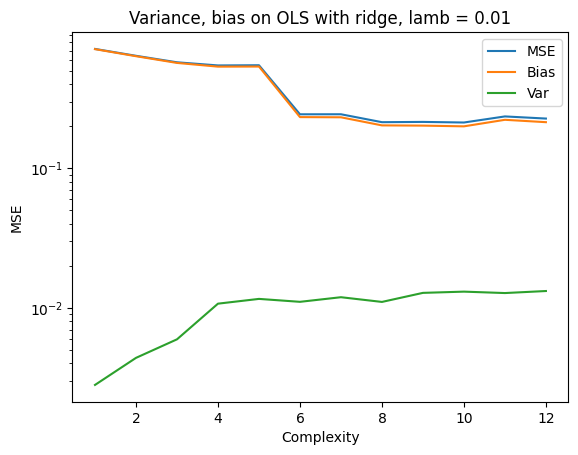

In [3]:
#OLS with Ridge

lamb = 0.01

    
mse = np.zeros(complexity)
bias = np.zeros(complexity)
var = np.zeros(complexity)

for i, deg in enumerate(degrees):
    mse[i], bias[i], var[i] = reg.bootstrap_ols(degree=deg, max_bootstrap_cycle=max_bootstrap_cycle[2], n_val=n_val[0], lamb=lamb, alpha=0)
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")
    
        
plt.figure(0)
plt.title(f"Variance, bias on OLS with ridge, lamb = {lamb}")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_ridge', dpi=300)
plt.show()

MSE: 0.72011431232713, Bias: 0.7173364331475561, Variance: 0.002777879179573793, Complexity: 1
MSE: 0.642753830877627, Bias: 0.6383828674078031, Variance: 0.004370963469823733, Complexity: 2
MSE: 0.5780490634020442, Bias: 0.5720961379232509, Variance: 0.00595292547879349, Complexity: 3
MSE: 0.577097791938479, Bias: 0.5710204125904034, Variance: 0.006077379348075862, Complexity: 4
MSE: 0.577097791938479, Bias: 0.5710204125904034, Variance: 0.006077379348075862, Complexity: 5
MSE: 0.28241825086720973, Bias: 0.27555009082938436, Variance: 0.006868160037825466, Complexity: 6
MSE: 0.2814535226753716, Bias: 0.27389021298946375, Variance: 0.007563309685907823, Complexity: 7
MSE: 0.2615046518475755, Bias: 0.2542012407945087, Variance: 0.007303411053066806, Complexity: 8
MSE: 0.2592143347974757, Bias: 0.250994108831197, Variance: 0.00822022596627846, Complexity: 9
MSE: 0.25514277035479277, Bias: 0.24681424428294726, Variance: 0.0083285260718456, Complexity: 10
MSE: 0.28135049032011183, Bias: 0.

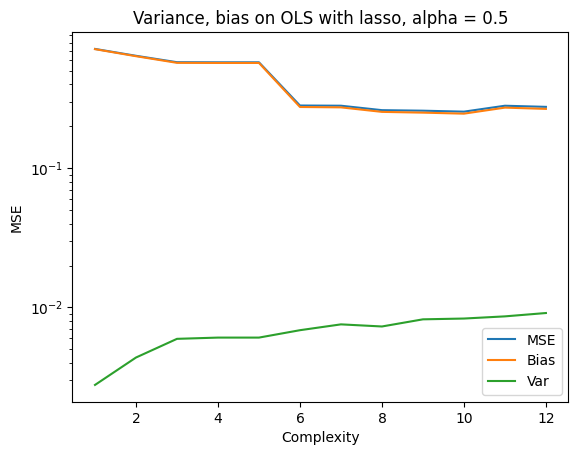

In [4]:
#OLS with Lasso

alpha = 0.5

    
mse = np.zeros(complexity)
bias = np.zeros(complexity)
var = np.zeros(complexity)

for i, deg in enumerate(degrees):
    mse[i], bias[i], var[i] = reg.bootstrap_ols(degree=deg, max_bootstrap_cycle=max_bootstrap_cycle[2], n_val=n_val[0], lamb=0, alpha=alpha)
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")
    
        
plt.figure(0)
plt.title(f"Variance, bias on OLS with lasso, alpha = {alpha}")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_lasso', dpi=300)
plt.show()

Bootstrap cycle: 1
Bootstrap cycle: 2
Bootstrap cycle: 3
Bootstrap cycle: 4
Bootstrap cycle: 5
Bootstrap cycle: 6
Bootstrap cycle: 7
Bootstrap cycle: 8
Bootstrap cycle: 9
Bootstrap cycle: 10
Bootstrap cycle: 11
Bootstrap cycle: 12
Bootstrap cycle: 13
Bootstrap cycle: 14
Bootstrap cycle: 15
Bootstrap cycle: 16
Bootstrap cycle: 17
Bootstrap cycle: 18
Bootstrap cycle: 19
Bootstrap cycle: 20
Bootstrap cycle: 21
Bootstrap cycle: 22
Bootstrap cycle: 23
Bootstrap cycle: 24
Bootstrap cycle: 25
Bootstrap cycle: 26
Bootstrap cycle: 27
Bootstrap cycle: 28
Bootstrap cycle: 29
Bootstrap cycle: 30
Bootstrap cycle: 31
Bootstrap cycle: 32
Bootstrap cycle: 33
Bootstrap cycle: 34
Bootstrap cycle: 35
Bootstrap cycle: 36
Bootstrap cycle: 37
Bootstrap cycle: 38
Bootstrap cycle: 39
Bootstrap cycle: 40
Bootstrap cycle: 41
Bootstrap cycle: 42
Bootstrap cycle: 43
Bootstrap cycle: 44
Bootstrap cycle: 45
Bootstrap cycle: 46
Bootstrap cycle: 47
Bootstrap cycle: 48
Bootstrap cycle: 49
Bootstrap cycle: 50
MSE: 0.93

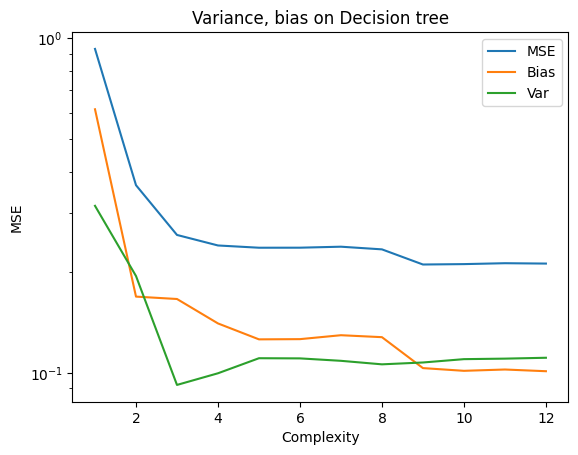

In [5]:
#Descision tree
mse, bias, var = reg.dt(degree=complexity, max_bootstrap_cycle=max_bootstrap_cycle[2], n_val=n_val[0])

for i in range(complexity):
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")

plt.figure(0)
plt.title(f"Variance, bias on Decision tree")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_dt', dpi=300)
plt.show()

Bootstrap cycle: 1
MSE: 0.4445164822352776, Bias: 0.3918913488196226, Variance: 0.05262513341565543, Complexity: 1
MSE: 0.2570111897251967, Bias: 0.21476670223022826, Variance: 0.0422444874949685, Complexity: 2
MSE: 0.16127471735629922, Bias: 0.13983181671858858, Variance: 0.02144290063771061, Complexity: 3
MSE: 0.13967888007755913, Bias: 0.11862949244317926, Variance: 0.021049387634379916, Complexity: 4
MSE: 0.14162244349015757, Bias: 0.12193051588103353, Variance: 0.019691927609124006, Complexity: 5
MSE: 0.14431858323582683, Bias: 0.12573050844800207, Variance: 0.018588074787824788, Complexity: 6
MSE: 0.14461410654055123, Bias: 0.12658900025616332, Variance: 0.018025106284387776, Complexity: 7
MSE: 0.14489881656614176, Bias: 0.12701503541740564, Variance: 0.017883781148736205, Complexity: 8
MSE: 0.13763155355393705, Bias: 0.11973562525023819, Variance: 0.017895928303698804, Complexity: 9
MSE: 0.13792573215629927, Bias: 0.11981542688626971, Variance: 0.018110305270029506, Complexity: 

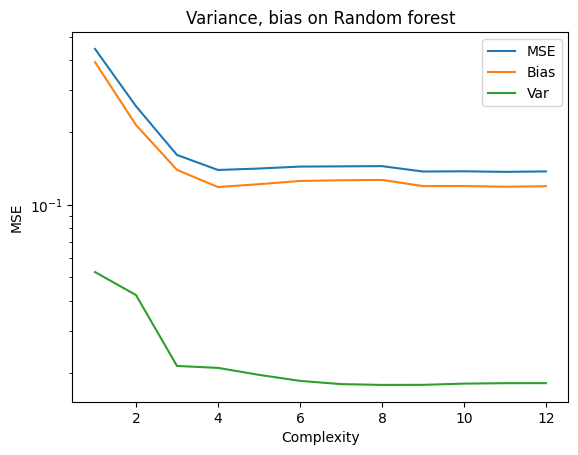

In [6]:
#Random forest
mse, bias, var = reg.rf(degree=complexity, max_bootstrap_cycle=max_bootstrap_cycle[0], n_val=n_val[0])

for i in range(complexity):
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")

plt.figure(0)
plt.title(f"Variance, bias on Random forest")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_rf', dpi=300)
plt.show()

Complexity: 1
Complexity: 2
Complexity: 3
Complexity: 4
Complexity: 5
Complexity: 6
Complexity: 7
Complexity: 8
Complexity: 9
Complexity: 10
Complexity: 11
Complexity: 12
Bootstrap cycle: 1
MSE: 5.292078094031184, Bias: 5.290653729630102, Variance: 0.0014243644010799522, Complexity: 1
MSE: 1.1098767870405732, Bias: 1.1037442798610988, Variance: 0.00613250717947457, Complexity: 2
MSE: 0.5891430201758964, Bias: 0.5745812134883116, Variance: 0.014561806687584666, Complexity: 3
MSE: 0.7319540487602231, Bias: 0.7031998516495809, Variance: 0.028754197110642123, Complexity: 4
MSE: 1.2212876686095921, Bias: 0.8825466938970511, Variance: 0.33874097471254117, Complexity: 5
MSE: 1.3420940227489089, Bias: 1.3264291354842255, Variance: 0.015664887264683305, Complexity: 6
MSE: 1.5042560491594172, Bias: 1.4914210494499864, Variance: 0.012834999709430464, Complexity: 7
MSE: 0.6938440936832615, Bias: 0.6872569655272278, Variance: 0.006587128156033407, Complexity: 8
MSE: 0.905664458665976, Bias: 0.89401

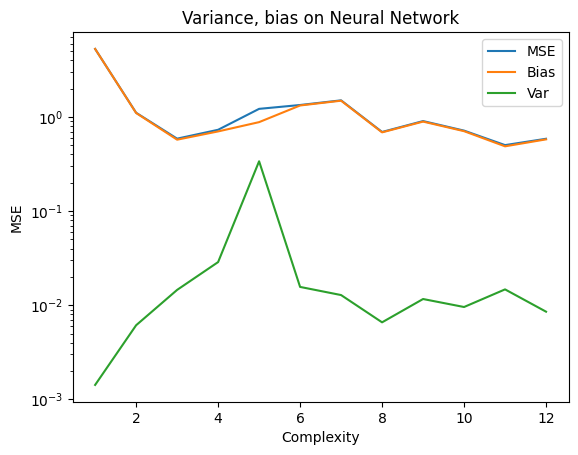

In [7]:
#Neural network
mse, bias, var = reg.nn(degree=complexity, max_bootstrap_cycle=max_bootstrap_cycle[0], n_val=n_val[0])
    
for i in range(complexity):
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")

plt.figure(0)
plt.title(f"Variance, bias on Neural Network")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_nn', dpi=300)
plt.show()